<a href="https://colab.research.google.com/github/bondarenko77/WEB/blob/main/WEB_Lab1_Bondarenko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Лабораторна робота 1**

Використаємо Elastic Stack Sample Data для отримання логів.

In [1]:
!wget https://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/nginx_logs/nginx_logs -O access.log
print("Файл завантажено успішно!")

--2026-02-16 13:35:57--  https://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/nginx_logs/nginx_logs
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6991577 (6.7M) [text/plain]
Saving to: ‘access.log’

access.log          100%[===================>]   6.67M  --.-KB/s    in 0.02s   

2026-02-16 13:35:57 (280 MB/s) - ‘access.log’ saved [6991577/6991577]

Файл завантажено успішно!


Напишемо код, який спочатку розбиває складні текстові рядки лог-файлу на зрозумілу таблицю, розділяючи IP-адреси, дати та технічні дані браузерів. Потім він автоматично підраховує унікальних відвідувачів за кожен день, групує їх за операційними системами та виокремлює запити від пошукових роботів. Наприкінці програма знаходить найбільш активні IP-адреси для виявлення аномалій і малює графік, який наочно показує зміни трафіку на ресурсі.

--------- ЗВІТ ПО ЛОГ-ФАЙЛУ ---------

a. Кількість унікальних користувачів за днями:
date
2015-05-17    118
2015-05-18    252
2015-05-19    276
2015-05-20    289
2015-05-21    280
2015-05-22    254
2015-05-23    259
2015-05-24    262
2015-05-25    283
2015-05-26    218
2015-05-27    288
2015-05-28    239
2015-05-29    247
2015-05-30    260
2015-05-31    267
2015-06-01    238
2015-06-02    230
2015-06-03    263
2015-06-04    101
Name: ip, dtype: int64
------------------------------

b. Топ-5 User-Agent (найактивніші):
user_agent
Debian APT-HTTP/1.3 (1.0.1ubuntu2)               11830
Debian APT-HTTP/1.3 (0.9.7.9)                    11365
Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.21)     6719
Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.16)     5740
Debian APT-HTTP/1.3 (0.8.16~exp12ubuntu10.22)     3855
Name: count, dtype: int64
------------------------------

c. Ранжування за операційними системами:
Windows: 142 запитів
Linux: 1614 запитів
iPhone/iOS: 0 запитів
Android: 0 запитів
Mac OS: 0

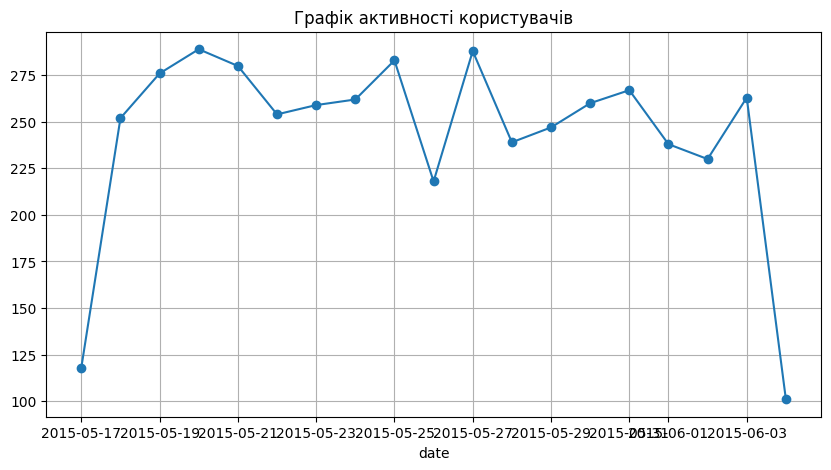

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 1. Парсинг файлу
log_pattern = r'(?P<ip>\S+) \S+ \S+ \[(?P<date>.*?)\] "(?P<request>.*?)" (?P<status>\d+) (?P<size>\S+) "(?P<referrer>.*?)" "(?P<user_agent>.*?)"'
data = []

with open('access.log', 'r') as f:
    for line in f:
        match = re.search(log_pattern, line)
        if match:
            data.append(match.groupdict())

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'], format='%d/%b/%Y:%H:%M:%S %z', errors='coerce')

# --- ВИКОНАННЯ ЗАВДАНЬ ---

print("--------- ЗВІТ ПО ЛОГ-ФАЙЛУ ---------\n")

# a. Користувачі за днями
print("a. Кількість унікальних користувачів за днями:")
daily_users = df.groupby(df['date'].dt.date)['ip'].nunique()
print(daily_users)
print("-" * 30)

# b. Ранжування за User-Agent
print("\nb. Топ-5 User-Agent (найактивніші):")
print(df['user_agent'].value_counts().head(5))
print("-" * 30)

# c. Ранжування за ОС (пошук за ключовими словами)
print("\nc. Ранжування за операційними системами:")
os_patterns = {'Windows': 'Windows', 'Linux': 'Linux', 'iPhone/iOS': 'iPhone|iPad', 'Android': 'Android', 'Mac OS': 'Macintosh'}
for name, pattern in os_patterns.items():
    count = df['user_agent'].str.contains(pattern, case=False, na=False).sum()
    print(f"{name}: {count} запитів")
print("-" * 30)

# d. Ранжування за країною (якщо немає бази IP, покажемо топ IP-адрес)
print("\nd. Топ IP-адрес (для аналізу географії):")
print(df['ip'].value_counts().head(5))
print("-" * 30)

# e. Виокремлення пошукових ботів
print("\ne. Пошукові боти:")
bots = df[df['user_agent'].str.contains('bot|spider|crawl', case=False, na=False)]
print(f"Всього запитів від ботів: {len(bots)}")
print("Приклади ботів:", bots['user_agent'].unique()[:3])
print("-" * 30)

# f. Детекція аномалій
print("\nf. Детекція аномалій (IP з найбільшою кількістю запитів):")
anomalies = df['ip'].value_counts().head(5)
print(anomalies)

# Візуалізація
daily_users.plot(kind='line', figsize=(10, 5), title='Графік активності користувачів', marker='o')
plt.grid(True)
plt.show()

**Висновки** - у ході роботи було розроблено скрипт на мові Python, який успішно перетворив сирі дані access.log у структурований датасет для аналізу поведінки користувачів. На основі отриманих результатів було визначено динаміку відвідуваності, ранжовано технічні параметри (ОС та User-Agents) і проведено ідентифікацію пошукових роботів. Аналіз виявив аномальну активність окремих IP-адрес.